In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/web-traffic-time-series-forecasting/sample_submission_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/sample_submission_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip


# Imports

In [2]:
import torch
import torch.nn as nn
from torch.nn import GRU
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim

In [3]:
device="cuda" if torch.cuda.is_available() else "cpu"

# Data pre-process

In [4]:
df=pd.read_csv('/kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip',compression="zip")

In [5]:
df.isnull().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

In [6]:
df.fillna(method='ffill', inplace=True)

/tmp/ipykernel_31/3970806690.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [7]:
df.isnull().sum()

Page          0
2015-07-01    0
2015-07-02    0
2015-07-03    0
2015-07-04    0
             ..
2016-12-27    0
2016-12-28    0
2016-12-29    0
2016-12-30    0
2016-12-31    0
Length: 551, dtype: int64

In [8]:
train=df.drop("Page",axis=1)

In [9]:
train.head(2)

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0


In [10]:
import matplotlib.pyplot as plt
def plot_time_series(df,row_num,start_col=1,ax=None):
    if ax is None:
        fig=plt.figure(facecolor='b',figsize=(10,6))
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()

    series_title=df.iloc[row_num,0]
    series_data=df.iloc[row_num,start_col :]
    series_data.plot(style="-",ax=ax)
    ax.set_title(f"Series title is : {series_title}")

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12509 (\N{KATAKANA LETTER PO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12465 (\N{KATAKANA LETTER KE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12514 (\N{KATAKANA LETTER MO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  func(*arg

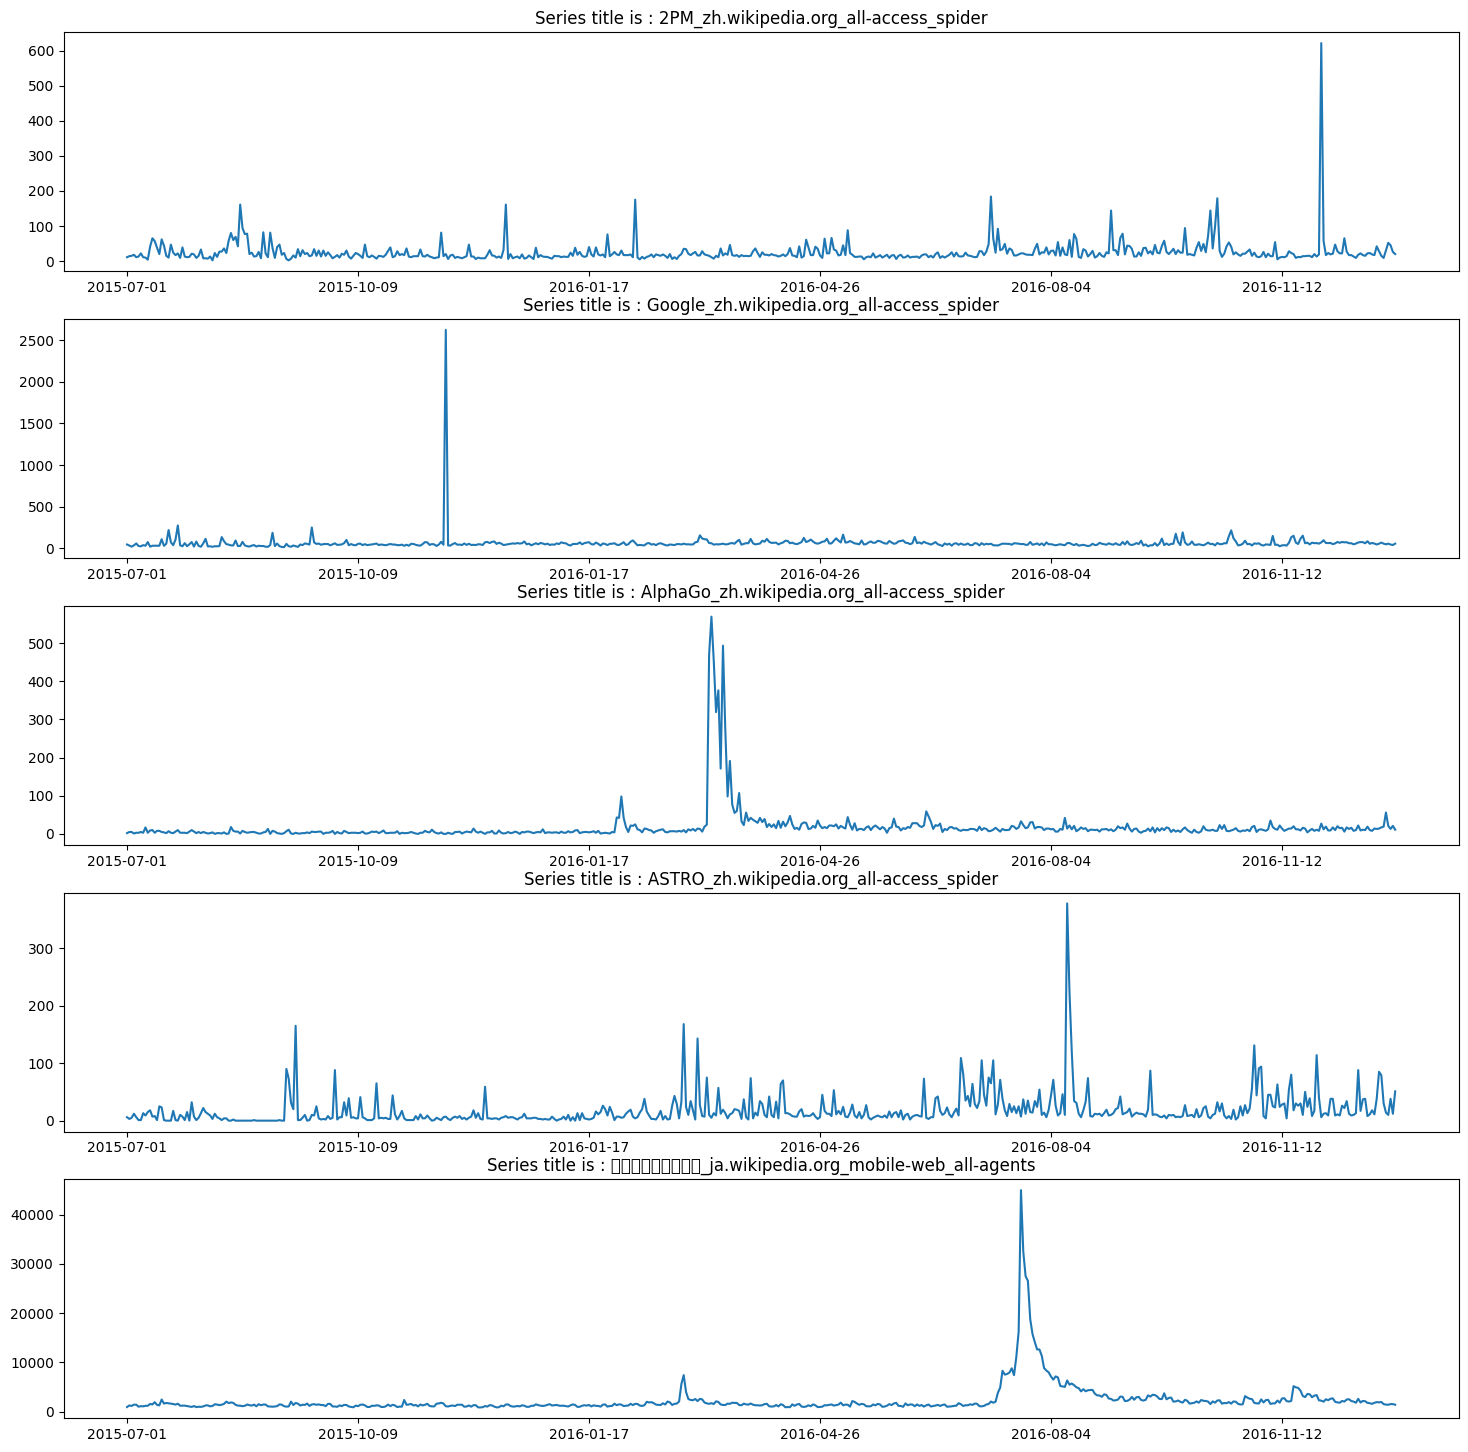

In [11]:
fig, axs  = plt.subplots(5,1,figsize=(18,18))
plot_time_series(df,1,1,ax=axs[0])
plot_time_series(df,65,1,ax=axs[1])
plot_time_series(df,13,1,ax=axs[2])
plot_time_series(df,10,1,ax=axs[3])
plot_time_series(df,56000,1,ax=axs[4])

In [12]:
rows=train.iloc[56000,:].values

In [13]:
print(rows[:10]),len(rows)

[ 960. 1286. 1193. 1440. 1444. 1038. 1143. 1109. 1209. 1229.]


(None, 550)

In [14]:
X=rows[0:549]
y=rows[1:550]

In [15]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [16]:
# Fit only on training data
scaler_x = MinMaxScaler()
X_train = scaler_x.fit_transform(X_train.reshape(-1, 1))
X_test = scaler_x.transform(X_test.reshape(-1, 1))

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))


In [17]:
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 1)

y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [18]:
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

# Training and evaluation loops

In [33]:
def train_model(model, X_train, y_train, criterion, optimizer, epochs=500, scheduler=None, log_interval=10):
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()

        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        if scheduler:
            scheduler.step()

        if (epoch + 1) % log_interval == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")


In [34]:
import matplotlib.pyplot as plt
import torch

def evaluate_and_plot(model, X_train, y_train, X_test, y_test, scaler, device, title_prefix=''):
    model.eval()
    
    with torch.no_grad():
        train_preds = model(X_train.to(device)).cpu().numpy()
        test_preds = model(X_test.to(device)).cpu().numpy()

    # Inverse transform
    train_preds = scaler.inverse_transform(train_preds)
    y_train_orig = scaler.inverse_transform(y_train.cpu().numpy())
    test_preds = scaler.inverse_transform(test_preds)
    y_test_orig = scaler.inverse_transform(y_test.cpu().numpy())

    # Plot train predictions
    plt.figure(figsize=(12, 6))
    plt.plot(y_train_orig, label='Actual Train')
    plt.plot(train_preds, label='Predicted Train')
    plt.legend()
    plt.title(f'{title_prefix} Train Predictions')
    plt.show()

    # Plot test predictions
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_orig, label='Actual Test')
    plt.plot(test_preds, label='Predicted Test')
    plt.legend()
    plt.title(f'{title_prefix} Test Predictions')
    plt.show()

In [35]:
from torchmetrics.regression import MeanAbsoluteError, R2Score, MeanSquaredError, MeanSquaredLogError
import torch

def evaluate_metrics(model, X_test, y_test, device):
    model.eval()
    with torch.no_grad():
        y_preds = model(X_test.to(device))

    # Clamp predictions and targets to be non-negative for MSLE
    y_preds = torch.clamp(y_preds, min=0)
    y_test = torch.clamp(y_test, min=0)

    # Initialize metrics
    mae = MeanAbsoluteError().to(device)
    r2 = R2Score().to(device)
    mse = MeanSquaredError().to(device)
    msle = MeanSquaredLogError().to(device)

    # Compute metric values
    mae_val = mae(y_preds, y_test.to(device))
    r2_val = r2(y_preds, y_test.to(device))
    mse_val = mse(y_preds, y_test.to(device))
    msle_val = msle(y_preds, y_test.to(device))

    # Print results
    print(f"MAE:  {mae_val.item():.4f}")
    print(f"R²:   {r2_val.item():.4f}")
    print(f"MSE:  {mse_val.item():.4f}")
    print(f"MSLE: {msle_val.item():.4f}")

    return {
        'mae': mae_val.item(),
        'r2': r2_val.item(),
        'mse': mse_val.item(),
        'msle': msle_val.item()
    }

In [36]:
import pandas as pd

def save_metrics_to_excel(metrics_dict, filename="metrics.xlsx"):
    """
    Saves metric values to an Excel file.

    Args:
        metrics_dict (dict): Dictionary with metric names as keys and values as floats.
        filename (str): Filename to save the Excel file to.
    """
    data = {
        "Metric": list(metrics_dict.keys()),
        "Value": list(metrics_dict.values())
    }

    df = pd.DataFrame(data)
    df.to_excel(filename, index=False, engine='openpyxl')
    print(f"Metrics saved to {filename}")


# RNN Model

In [37]:
class SimpleRNN(nn.Module):
    def __init__(self,input_shape,hidden_shape,output_shape):
        super(SimpleRNN,self).__init__()
        self.RNN=nn.RNN(input_shape,hidden_shape,num_layers=2,batch_first=True,dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_shape, 64),   # hidden_shape
            nn.ReLU(),                         # ReLU activation
            nn.Dropout(0.2),                   # Dropout layer for regularization
            nn.Linear(64, output_shape)        # Final output layer
        )

    def forward(self,x):
        rnn_out,_=self.RNN(x)
        out=self.fc(rnn_out[:, -1, :])
        return out

In [38]:
model_0=SimpleRNN(1,32,1).to(device)

In [39]:
loss_fn=nn.MSELoss()
optimizer = optim.Adam(model_0.parameters(), lr=0.01)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [40]:
train_model(model_0,X_train=X_train,y_train=y_train,criterion=loss_fn,optimizer=optimizer,epochs=500,log_interval=10)

Epoch [10/500], Loss: 0.006805
Epoch [20/500], Loss: 0.004569
Epoch [30/500], Loss: 0.002308
Epoch [40/500], Loss: 0.001533
Epoch [50/500], Loss: 0.002424
Epoch [60/500], Loss: 0.001490
Epoch [70/500], Loss: 0.001628
Epoch [80/500], Loss: 0.001308
Epoch [90/500], Loss: 0.001556
Epoch [100/500], Loss: 0.001502
Epoch [110/500], Loss: 0.001322
Epoch [120/500], Loss: 0.001155
Epoch [130/500], Loss: 0.001778
Epoch [140/500], Loss: 0.001445
Epoch [150/500], Loss: 0.001642
Epoch [160/500], Loss: 0.001055
Epoch [170/500], Loss: 0.001399
Epoch [180/500], Loss: 0.001372
Epoch [190/500], Loss: 0.001228
Epoch [200/500], Loss: 0.001273
Epoch [210/500], Loss: 0.001453
Epoch [220/500], Loss: 0.001532
Epoch [230/500], Loss: 0.001418
Epoch [240/500], Loss: 0.001320
Epoch [250/500], Loss: 0.001326
Epoch [260/500], Loss: 0.001600
Epoch [270/500], Loss: 0.001063
Epoch [280/500], Loss: 0.000969
Epoch [290/500], Loss: 0.001644
Epoch [300/500], Loss: 0.000936
Epoch [310/500], Loss: 0.001040
Epoch [320/500], 

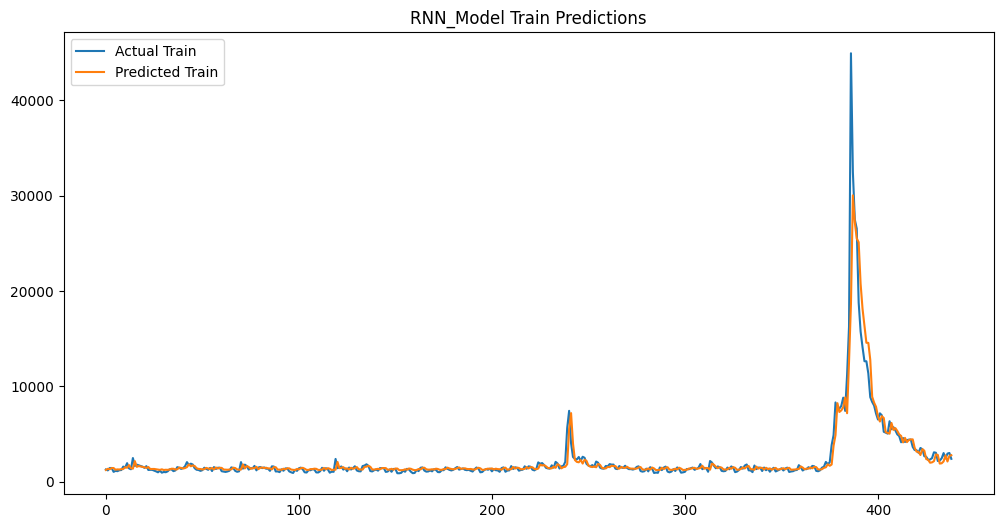

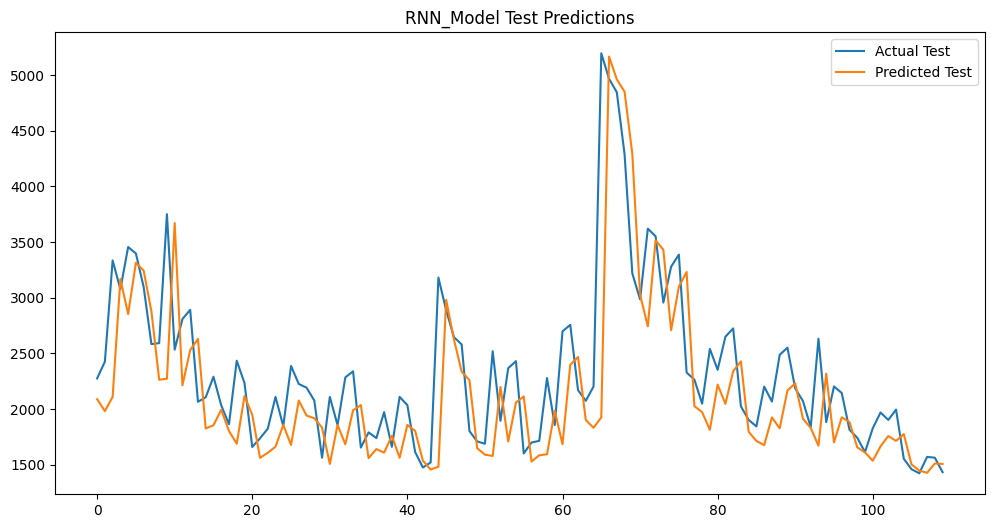

In [41]:
evaluate_and_plot(model_0, X_train, y_train, X_test, y_test, scaler_y, device, title_prefix='RNN_Model')

In [42]:
rnn_metrics=evaluate_metrics(model_0, X_test, y_test, device)

MAE:  0.0086
R²:   0.3892
MSE:  0.0002
MSLE: 0.0002


In [44]:
save_metrics_to_excel(rnn_metrics, filename="rnn_metrics.xlsx")

Metrics saved to rnn_metrics.xlsx


# LSTM Model

In [45]:
class LSTM(nn.Module):
    def __init__(self,input_shape,hidden_shape,output_shape):
        super(LSTM,self).__init__()
        self.lstm=nn.LSTM(input_shape,hidden_shape,num_layers=2,batch_first=True,dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_shape, 64),   # hidden_shape
            nn.ReLU(),                         # ReLU activation
            nn.Dropout(0.2),                   # Dropout layer for regularization
            nn.Linear(64, output_shape)        # Final output layer
        )

    def forward(self,x):
        lstm_out,_=self.lstm(x)
        out=self.fc(lstm_out[:, -1, :])
        return out

In [46]:
model_1=LSTM(1,32,1).to(device)

In [47]:
loss_fn=nn.MSELoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.01)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [48]:
train_model(model_1,X_train=X_train,y_train=y_train,criterion=loss_fn,optimizer=optimizer,epochs=500,log_interval=10)

Epoch [10/500], Loss: 0.008001
Epoch [20/500], Loss: 0.007189
Epoch [30/500], Loss: 0.005833
Epoch [40/500], Loss: 0.002186
Epoch [50/500], Loss: 0.001870
Epoch [60/500], Loss: 0.001759
Epoch [70/500], Loss: 0.001436
Epoch [80/500], Loss: 0.001400
Epoch [90/500], Loss: 0.001332
Epoch [100/500], Loss: 0.001126
Epoch [110/500], Loss: 0.001430
Epoch [120/500], Loss: 0.001279
Epoch [130/500], Loss: 0.001282
Epoch [140/500], Loss: 0.001207
Epoch [150/500], Loss: 0.001068
Epoch [160/500], Loss: 0.001679
Epoch [170/500], Loss: 0.001482
Epoch [180/500], Loss: 0.001264
Epoch [190/500], Loss: 0.001508
Epoch [200/500], Loss: 0.001182
Epoch [210/500], Loss: 0.001290
Epoch [220/500], Loss: 0.001185
Epoch [230/500], Loss: 0.001287
Epoch [240/500], Loss: 0.000979
Epoch [250/500], Loss: 0.001016
Epoch [260/500], Loss: 0.001295
Epoch [270/500], Loss: 0.000872
Epoch [280/500], Loss: 0.001420
Epoch [290/500], Loss: 0.001520
Epoch [300/500], Loss: 0.001339
Epoch [310/500], Loss: 0.001668
Epoch [320/500], 

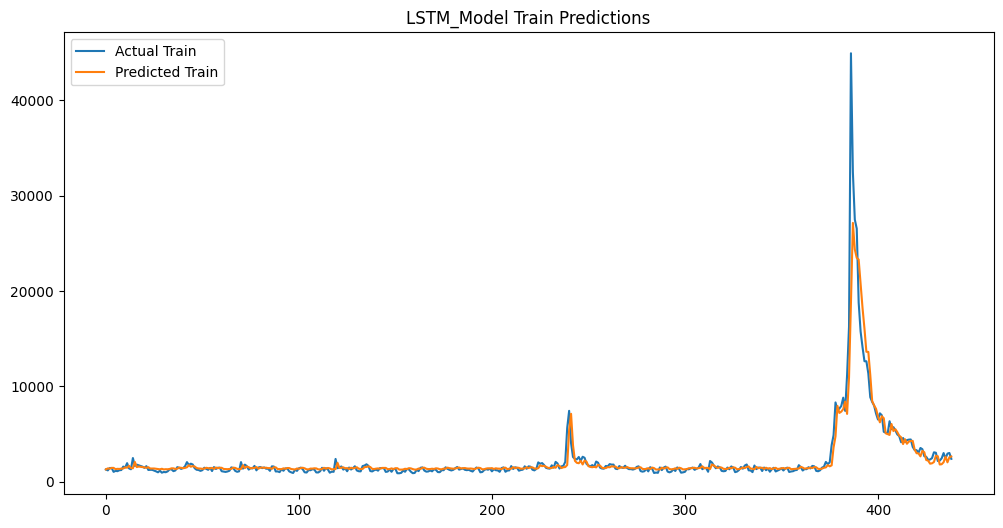

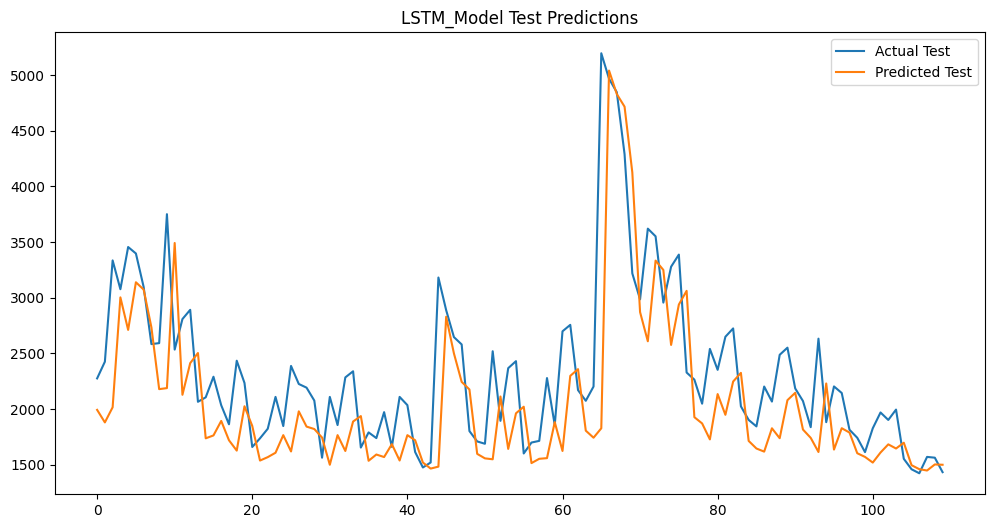

In [49]:
evaluate_and_plot(model_1, X_train, y_train, X_test, y_test, scaler_y, device, title_prefix='LSTM_Model')

In [50]:
lstm_metrics=evaluate_metrics(model_1, X_test, y_test, device)

MAE:  0.0092
R²:   0.3362
MSE:  0.0002
MSLE: 0.0002


# GRU-Model

In [ ]:
class gru_model(nn.Module):
    def __init__(self,input_shape,hidden_shape,output_shape):
        super(gru_model,self).__init__()
        self.GRU=nn.GRU(input_shape,hidden_shape,num_layers=2,batch_first=True,dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_shape, 64),   
            nn.ReLU(),                         # ReLU activation
            nn.Dropout(0.2),                   # Dropout layer for regularization
            nn.Linear(64, output_shape)        # Final output layer
        )

    def forward(self,x):
        gru_out,_=self.GRU(x)
        out=self.fc(gru_out[:, -1, :])
        return out

In [ ]:
model_2=gru_model(1,32,1).to(device)

In [ ]:
loss_fn=nn.MSELoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.01)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [ ]:
train_model(model_2,X_train=X_train,y_train=y_train,criterion=loss_fn,optimizer=optimizer,epochs=500,log_interval=10)

In [26]:
evaluate_and_plot(model_2, X_train, y_train, X_test, y_test, scaler_y, device, title_prefix='GRU_Model')

NameError: name 'model_2' is not defined

In [ ]:
gru_metrics=evaluate_metrics(model_2, X_test, y_test, device)

# Bi-LSTM Model

In [ ]:
class bilstm(nn.Module):
    def __init__(self,input_shape,hidden_shape,output_shape):
        super(bilstm,self).__init__()
        self.lstm=nn.LSTM(input_size=input_shape,hidden_size=hidden_shape,num_layers=2,batch_first=True,bidirectional=True,dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_shape, 64),   # 2 * hidden_shape because the LSTM is bidirectional
            nn.ReLU(),                         # ReLU activation
            nn.Dropout(0.2),                   # Dropout layer for regularization
            nn.Linear(64, output_shape)        # Final output layer
        )

    def forward(self, x):
        output, _ = self.lstm(x)
        out = self.fc(output[:, -1, :])  # take only last time step
        return out  # shape: [batch, output_size]

In [ ]:
model_3=bilstm(1,32,1).to(device)

In [27]:
loss_fn=nn.MSELoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.01)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

NameError: name 'model_3' is not defined

In [ ]:
train_model(model_3,X_train=X_train,y_train=y_train,criterion=loss_fn,optimizer=optimizer,epochs=500,log_interval=10)

In [ ]:
evaluate_and_plot(model_3, X_train, y_train, X_test, y_test, scaler_y, device, title_prefix='BiLSTM_Model')

In [ ]:
bilstm_metrics=evaluate_metrics(model_3, X_test, y_test, device)

# Bi-GRU Model

In [ ]:
class biGRU(nn.Module):
    def __init__(self,input_shape,hidden_shape,output_shape):
        super(biGRU,self).__init__()
        self.gru=nn.GRU(input_size=input_shape,hidden_size=hidden_shape,num_layers=2,batch_first=True,bidirectional=True,dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_shape, 64),   # 2 * hidden_shape because the LSTM is bidirectional
            nn.ReLU(),                         # ReLU activation
            nn.Dropout(0.2),                   # Dropout layer for regularization
            nn.Linear(64, output_shape)        # Final output layer
        )

    def forward(self, x):
        output, _ = self.gru(x)
        out = self.fc(output[:, -1, :])  # take only last time step
        return out  # shape: [batch, output_size]

In [ ]:
model_4=biGRU(1,32,1).to(device)

In [ ]:
criterion=nn.MSELoss()
optimizer=optim.Adam(model_4.parameters(),lr=0.01)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [ ]:
train_model(model_4,X_train=X_train,y_train=y_train,criterion=loss_fn,optimizer=optimizer,epochs=500,log_interval=10)

In [ ]:
evaluate_and_plot(model_4, X_train, y_train, X_test, y_test, scaler_y, device, title_prefix='BiGRU_Model')

In [28]:
bigru_metrics=evaluate_metrics(model_4, X_test, y_test, device)

NameError: name 'model_4' is not defined

# Bi-RNN Model

In [29]:
class birnn(nn.Module):
    def __init__(self,input_shape,hidden_shape,output_shape):
        super(birnn,self).__init__()
        self.rnn=nn.RNN(input_size=input_shape,hidden_size=hidden_shape,num_layers=2,batch_first=True,bidirectional=True,dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_shape, 64),   # 2 * hidden_shape because the LSTM is bidirectional
            nn.ReLU(),                         # ReLU activation
            nn.Dropout(0.2),                   # Dropout layer for regularization
            nn.Linear(64, output_shape)        # Final output layer
        )

    def forward(self, x):
        output, _ = self.rnn(x)
        out = self.fc(output[:, -1, :])  # take only last time step
        return out  # shape: [batch, output_size]

In [30]:
model_5=birnn(1,32,1).to(device)

In [31]:
criterion=nn.MSELoss()
optimizer=optim.Adam(model_5.parameters(),lr=0.01)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [32]:
train_model(model_5,X_train=X_train,y_train=y_train,criterion=loss_fn,optimizer=optimizer,epochs=500,log_interval=10)

NameError: name 'train_model' is not defined

In [ ]:
evaluate_and_plot(model_5, X_train, y_train, X_test, y_test, scaler_y, device, title_prefix='BiRNN_Model')

In [ ]:
birnn_metrics=evaluate_metrics(model_5, X_test, y_test, device)